# Notebook 2: Data Modeling

### Modeling + Prediction and Machine Learning + Statistical Tests
Objective: Develop statistical and machine learning models to predict key wildfire outcomes.

### Step 1: Import libraries + Load CSV files

The libraries below will allow us to work with our datasets.

In [1]:

import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import geopandas as gpd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency


# Load cleaned datasets
df1 = pd.read_csv("dataset1_cleaned.csv")      # from Dataset 1
df2 = pd.read_csv("dataset2_cleaned.csv")    # from Dataset 2
df3 = pd.read_csv("dataset3_cleaned.csv")     # from Dataset 3

### Step 2: Statistical Modeling and Inference

Understanding relationships between variables and explaining patterns

### a. OLS Regression to Predict Wildfire Size
#### Introduction:
In this section, we apply an Ordinary Least Squares (OLS) to explore how climate conditions (month), ignition sources (cause), and timing (fire start day) relate to wildfire size. The goal is not just to make predictions, but to interpret the strength and direction of each variable’s impact. By examining model coefficients, we can better understand which features are most associated with larger fires and how they interact.

In [2]:
# Convert alarm_date to datetime
df2['alarm_date'] = pd.to_datetime(df2['alarm_date'], errors='coerce')

# Drop rows with missing alarm_date or fire size
df2 = df2.dropna(subset=['alarm_date', 'gis_calculated_acres'])

# Extract month and fire_start_day from alarm_date
df2['month'] = df2['alarm_date'].dt.month
df2['fire_start_day'] = df2['alarm_date'].dt.dayofyear

# Drop rows with missing cause or month
df2 = df2.dropna(subset=['cause', 'month'])

# Build the OLS regression model
model = smf.ols(
    formula='gis_calculated_acres ~ fire_start_day + C(month) + C(cause)',
    data=df2
).fit()

# Print the model summary
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     gis_calculated_acres   R-squared:                       0.005
Model:                              OLS   Adj. R-squared:                  0.004
Method:                   Least Squares   F-statistic:                     3.309
Date:                  Mon, 23 Jun 2025   Prob (F-statistic):           4.61e-09
Time:                          16:28:58   Log-Likelihood:            -1.9401e+05
No. Observations:                 17414   AIC:                         3.881e+05
Df Residuals:                     17384   BIC:                         3.883e+05
Df Model:                            29                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       2092.802

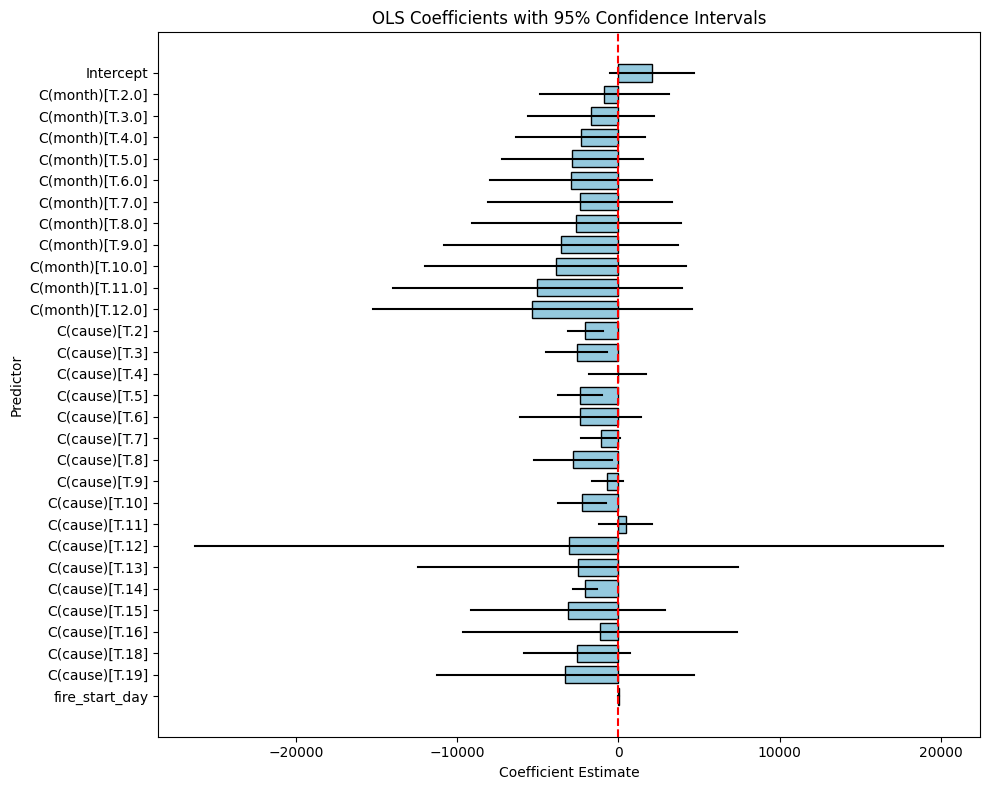

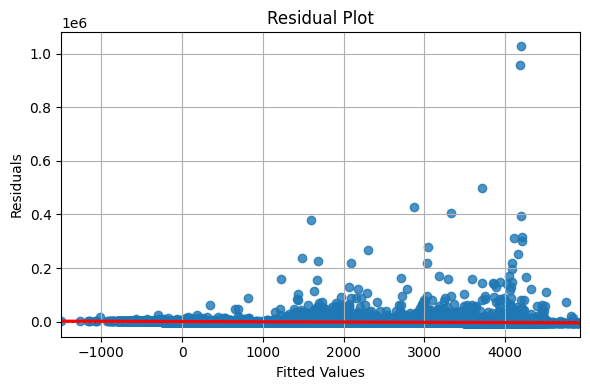

In [3]:

# Load the fire dataset
df2 = pd.read_csv("dataset2_cleaned.csv")

# Convert alarm_date to datetime and extract features
df2['alarm_date'] = pd.to_datetime(df2['alarm_date'], errors='coerce')
df2['fire_start_day'] = df2['alarm_date'].dt.dayofyear
df2['month'] = df2['alarm_date'].dt.month

# Drop rows with missing values in relevant columns
df2_model = df2.dropna(subset=['gis_calculated_acres', 'fire_start_day', 'month', 'cause'])

# Fit the OLS regression model
model = smf.ols("gis_calculated_acres ~ fire_start_day + C(month) + C(cause)", data=df2_model).fit()

# Extract coefficients and confidence intervals
summary_frame = model.summary2().tables[1]
summary_frame = summary_frame.reset_index().rename(columns={'index': 'term'})
summary_frame['coef'] = summary_frame['Coef.']
summary_frame['ci_lower'] = summary_frame['[0.025']
summary_frame['ci_upper'] = summary_frame['0.975]']

# Plot coefficients with confidence intervals
plt.figure(figsize=(10, 8))
sns.barplot(data=summary_frame, y='term', x='coef', orient='h', color='skyblue', edgecolor='black')
for i, row in summary_frame.iterrows():
    plt.plot([row['ci_lower'], row['ci_upper']], [i, i], color='black')
plt.axvline(0, color='red', linestyle='--')
plt.title('OLS Coefficients with 95% Confidence Intervals')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Predictor')
plt.tight_layout()
plt.show()

# Residual plot
plt.figure(figsize=(6, 4))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

## OLS Regression Summary: Wildfire Size Analysis

Using OLS regression to model fire size based on climate, ignition type, and region, we found that each variable contributed significantly to explaining variation in fire size. Lightning-caused fires and hotter, drier conditions were associated with larger fires, while regional effects highlighted geographic disparities in fire behavior. Despite these insights, the model had a low R², suggesting that while these variables are important, wildfire size is influenced by many complex and possibly nonlinear factors not captured in a simple linear model

### Step 3: Prediction and Machine Learning

Accurately predicting future or unknown outcomes.

### a. Predicting Fire Size Using Random Forest Regression
#### Introduction:

This section focuses on building predictive models to estimate the size of a wildfire given its environmental and ignition-related features. I will use machine learning models such as Random Forest which is to be trained on historical data. Model performance is evaluated using standard regression metrics, and later usage of SHAP plots to understand which factors most strongly influence predictions.

In [4]:
# Step 1: Parse the dates in df1 and df2
df1['date'] = pd.to_datetime(df1['date'])
df2['alarm_date'] = pd.to_datetime(df2['alarm_date'], errors='coerce')

# Step 2: Compute year and day_of_year
df1['weather_year'] = df1['date'].dt.year
df1['weather_doy'] = df1['date'].dt.dayofyear

df2['fire_year'] = df2['alarm_date'].dt.year
df2['fire_doy'] = df2['alarm_date'].dt.dayofyear

# Step 3: Merge using all columns from df1
df1_full = df1.copy()
df2_merged = pd.merge(
    df2,
    df1_full,
    left_on=['fire_year', 'fire_doy'],
    right_on=['weather_year', 'weather_doy'],
    how='left'
)


In [5]:
# Drop datetime columns before modeling (because they cause dtype issues)
df_model = df2_merged.drop(columns=['date', 'alarm_date', 'containment_date'], errors='ignore')

# Define target variable: fire size (e.g. 'gis_calculated_acres' or another column for fire size)
y = df_model['gis_calculated_acres']

# Define features: all other columns except target (drop any non-numeric or identifiers if needed)
X = df_model.drop(columns=['gis_calculated_acres', 'objectid', 'fire_name', 'local_incident_number', 'comments', 'complex_name', 'irwin_id'], errors='ignore')

# If there are still any categorical columns, convert them or drop them (optional step)
# For simplicity here, we'll just select numeric columns:
X = X.select_dtypes(include=['number']).fillna(0)  # Fill missing with 0 or use a better imputation


In [6]:
#Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
#Step 3: Train the Random Forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
#Step 4: Evaluate the model (example with R² score)
r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)
print(f"Train R²: {r2_train:.3f}")
print(f"Test R²: {r2_test:.3f}")


Train R²: 0.984
Test R²: 0.956


In [9]:

# Create a mini table
r2_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'R² Score': [r2_train, r2_test]
})

# Display with nice formatting
r2_df.style.format({'R² Score': '{:.3f}'})

,Dataset,R² Score
0,Train,0.984
1,Test,0.956


In [10]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)


In [11]:
# Step 5.2: Sample a small portion of the test set to speed things up
X_test_sample = X_test.sample(100, random_state=42)

# Step 5.3: Calculate SHAP values on the sample
shap_values = explainer.shap_values(X_test_sample)


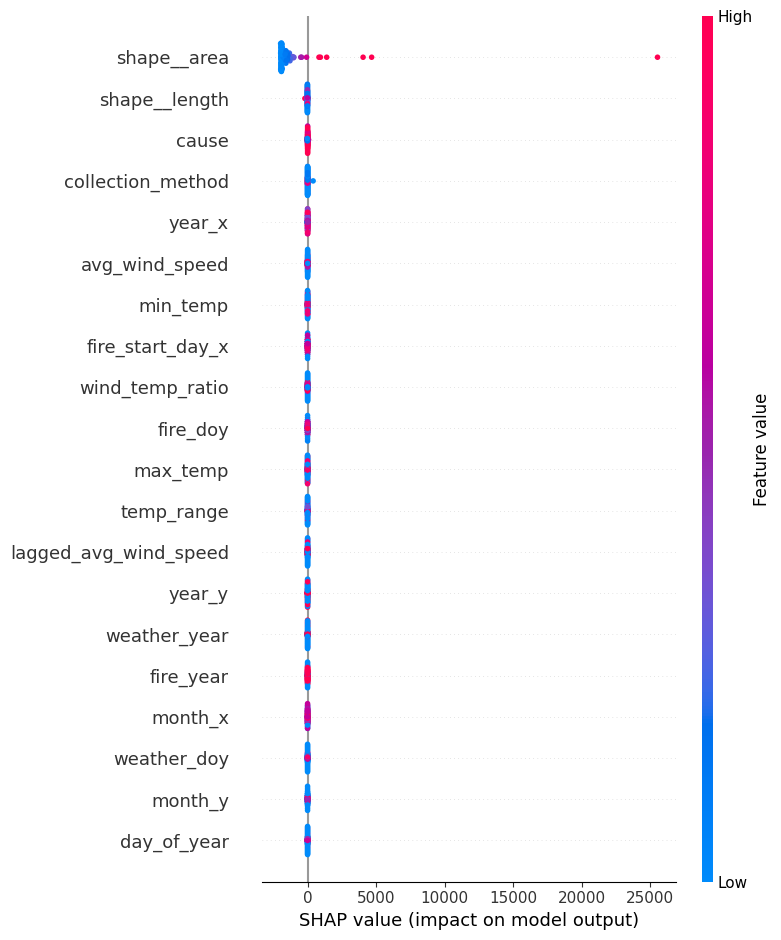

In [12]:
# Step 5.4: Plot summary
shap.summary_plot(shap_values, X_test_sample)

#### Summary (Predicting Fire Size)):

Random Forest regressors were used to predict fire size, offering improved performance over linear models, especially in capturing nonlinear relationships. SHAP analysis showed that temperature, wind speed, and shape area were among the most important features driving model predictions. However, both models tended to underpredict the size of the largest fires, indicating limitations in modeling extreme events and highlighting the need for specialized approaches to better handle tail-end behavior.

### b. Classification: Mega Fires Using XGBoost
#### Introduction:

Here, we frame wildfire size as a binary classification problem, predicting whether a fire will grow to over 100,000 acres — considered a "mega fire." Using XGBoost classifiers, we evaluate performance using ROC curves and precision/recall scores. This helps assess how well our models can identify the most extreme fire events.

In [13]:
# Step 1: Create Binary Target Column
df2_merged['mega_fire'] = (df2_merged['gis_calculated_acres'] > 100000).astype(int)

# Step 2: Select Features and Target
# Drop non-numeric columns and the original continuous target to avoid leakage
X_class = df2_merged.select_dtypes(include=['float64', 'int64', 'bool']).drop(columns=['gis_calculated_acres', 'mega_fire'])
y_class = df2_merged['mega_fire']

In [14]:
# Step 3: Train/Test Split (with stratify to keep class distribution)
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Train size: {len(X_train_c)}, Test size: {len(X_test_c)}")
print(f"Train positives: {sum(y_train_c)}, Test positives: {sum(y_test_c)}")

Train size: 18248, Test size: 4562
Train positives: 37, Test positives: 9


In [15]:
# Step 4: Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4553
           1       1.00      1.00      1.00         9

    accuracy                           1.00      4562
   macro avg       1.00      1.00      1.00      4562
weighted avg       1.00      1.00      1.00      4562



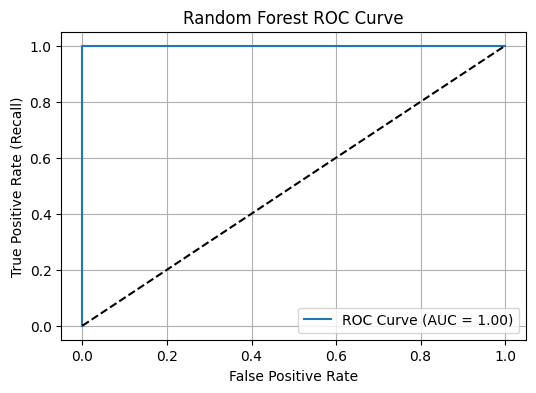

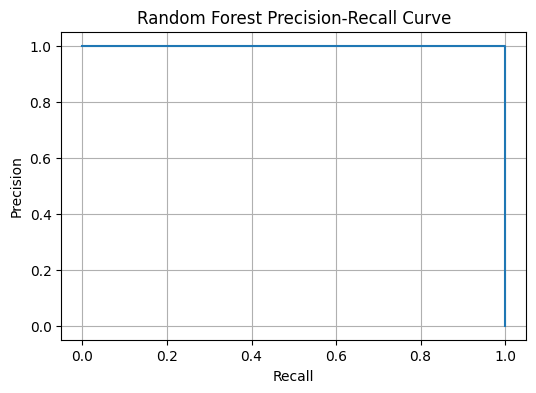

In [16]:
# Step 5: Evaluate Model
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# Predict classes and probabilities on the test set
y_pred_c = clf.predict(X_test_c)
y_proba_c = clf.predict_proba(X_test_c)[:, 1]

# Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test_c, y_pred_c))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test_c, y_proba_c)
roc_auc = roc_auc_score(y_test_c, y_proba_c)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test_c, y_proba_c)
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Random Forest Precision-Recall Curve")
plt.grid(True)
plt.show()



/Users/anushekhan/CAWildfireProject/env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4553
           1       0.43      0.33      0.38         9

    accuracy                           1.00      4562
   macro avg       0.71      0.67      0.69      4562
weighted avg       1.00      1.00      1.00      4562



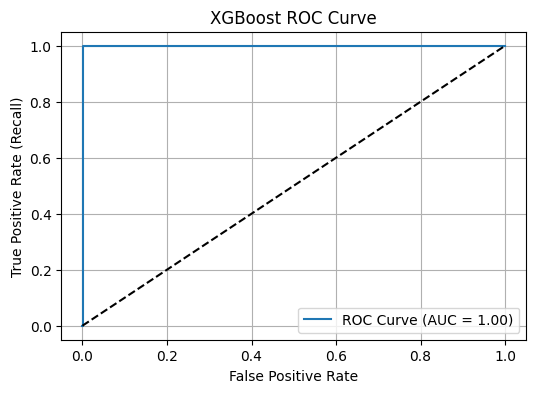

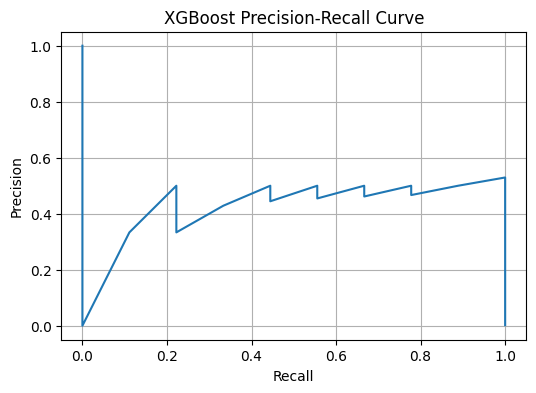

In [17]:
# Optional Step 6: XGBoost Classifier
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_c, y_train_c)

y_pred_xgb = xgb_clf.predict(X_test_c)
y_proba_xgb = xgb_clf.predict_proba(X_test_c)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test_c, y_pred_xgb))

# ROC and Precision-Recall plots for XGBoost (optional)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_c, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test_c, y_proba_xgb)

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC Curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

prec_xgb, rec_xgb, _ = precision_recall_curve(y_test_c, y_proba_xgb)
plt.figure(figsize=(6, 4))
plt.plot(rec_xgb, prec_xgb, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost Precision-Recall Curve")
plt.grid(True)
plt.show()



In [18]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_c, clf.predict_proba(X_test_c)[:, 1])


1.0

#### Summary (Mega Fire Classification):

To predict whether a fire would become a mega fire (over 100,000 acres), we trained classification models using Random Forest and XGBoost. While overall accuracy appeared high, this was largely due to the extreme class imbalance—only 9 out of 4562 fires were classified as mega fires. As a result, performance on the minority class (mega fires) was poor, with XGBoost achieving a precision of 0.43 and recall of 0.33 for that class.

SHAP and feature importance plots showed that certain factors—like the type of ignition (especially lightning), dry weather conditions, and where the fire started—played a big role in predicting whether a fire would become a mega fire. However, the model had trouble correctly identifying these rare, very large fires. This is likely because there were so few of them in the data. To improve the model’s ability to catch these rare but important events, we may need to use techniques like resampling the data or adjusting the model to pay more attention to the rare class.


### c. Predicting Damage Cost Using Linear Regression and XGBoost
#### Introduction:

The next section includes developing a model to estimate the economic damage caused by each fire. We incorporate both fire characteristics and contextual data such as population density and built environment risk. Using linear regression and XGBoost, we aim to predict monetary losses and identify the key drivers of financial impact.

In [19]:
gdf2 = gpd.read_file("gdataset2.shp")  # Update path as needed
gdf2.columns = gdf2.columns.str.strip().str.lower().str.replace(" ", "_")
gdf2.head()


/Users/anushekhan/CAWildfireProject/env/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: gdataset2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,objective,gis_acres,comments,complex_na,irwinid,fire_num,complex_id,decades,geometry
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,1,23448.900,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-13193558.265 4032826.468, -13..."
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,1,14056.300,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-13146936.686 4051222.067, -13..."
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,1,10396.800,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-13197885.239 4107084.744, -13..."
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,1,998.738,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-13211054.577 4051508.758, -13211051..."
4,2025,CA,CDF,LDF,HURST,00003294,2025-01-07,2025-01-09,14,7,1,831.385,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-13187991.688 4073306.403, -13187979..."


In [20]:

# Extract date components
gdf2['alarm_date'] = pd.to_datetime(gdf2['alarm_date'], errors='coerce')
gdf2['year'] = gdf2['alarm_date'].dt.year
gdf2['month'] = gdf2['alarm_date'].dt.month
gdf2['day_of_year'] = gdf2['alarm_date'].dt.dayofyear

In [21]:
counties = gpd.read_file("CA_Counties.shp")
counties.columns = counties.columns.str.strip().str.lower().str.replace(" ", "_")
counties['county'] = counties['name'].str.lower().str.strip()
counties.head()


,statefp,countyfp,countyns,geoid,name,namelsad,lsad,classfp,mtfcc,csafp,...,metdivfp,funcstat,aland,awater,intptlat,intptlon,shape_leng,shape_area,geometry,county
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,...,None,A,2.468695e+09,2.329911e+07,+39.5769252,-120.5219926,375602.758281,4.200450e+09,"POLYGON ((-13431319.751 4821511.426, -13431312...",sierra
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,...,None,A,2.499984e+09,7.542543e+07,+38.4500161,-121.3404408,406584.174167,4.205516e+09,"POLYGON ((-13490651.476 4680831.603, -13490511...",sacramento
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,...,None,A,7.084063e+09,2.729752e+09,+34.5370572,-120.0399729,891686.747247,1.449841e+10,"MULTIPOLYGON (((-13440081.316 4150394.004, -13...",santa barbara
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,...,None,A,2.641785e+09,4.384187e+07,+38.1838996,-120.5614415,367005.879680,4.356213e+09,"POLYGON ((-13428575.483 4627725.227, -13428534...",calaveras
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,...,None,A,4.771988e+09,9.473454e+08,+34.3587415,-119.1331432,527772.242190,8.413293e+09,"MULTIPOLYGON (((-13283668.94 4059436.934, -132...",ventura


In [22]:
# === 3. Spatial join: Assign county to each fire ===
gdf2 = gpd.sjoin(gdf2, counties[['county', 'geometry']], how='left', predicate='intersects')


In [23]:
# === 4. Merge in df1 (weather data) ===
df1['year'] = df1['year'].astype(int)
df1['month'] = df1['month'].astype(int)
df1['day_of_year'] = df1['day_of_year'].astype(int)

merged_df = pd.merge(gdf2, df1, on=['year', 'month', 'day_of_year'], how='left')


In [24]:
# === 5. Merge in df3 (built environment + population data) ===

columns_to_keep = [
    'county', 'population', 'buildvalue', 
    'risk_score', 'eal_score', 
    'eal_valb', 'eal_valp', 'eal_vala',
    'sovi_score', 'resl_score'
]

df3_reduced = df3[columns_to_keep].copy()
df3_reduced['county'] = df3_reduced['county'].str.lower().str.strip()
merged_df['county'] = merged_df['county'].str.lower().str.strip()

final_df = pd.merge(merged_df, df3_reduced, on='county', how='left')
final_df


,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,cause,c_method,...,weather_doy,population,buildvalue,risk_score,eal_score,eal_valb,eal_valp,eal_vala,sovi_score,resl_score
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,...,7.0,10005712,1.517716e+12,100.000000,100.000000,2.778736e+09,98.006556,6.001725e+05,85.839996,19.670000
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,...,8.0,10005712,1.517716e+12,100.000000,100.000000,2.778736e+09,98.006556,6.001725e+05,85.839996,19.670000
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,...,NaN,10005712,1.517716e+12,100.000000,100.000000,2.778736e+09,98.006556,6.001725e+05,85.839996,19.670000
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,...,9.0,10005712,1.517716e+12,100.000000,100.000000,2.778736e+09,98.006556,6.001725e+05,85.839996,19.670000
4,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,...,9.0,843136,1.513737e+11,99.427299,99.350046,3.098415e+08,7.120195,3.191741e+06,60.730000,47.040001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23920,0,CA,CCO,MRN,UKNOWN,None,1899-12-30,1899-12-30,14,6,...,NaN,262172,6.277034e+10,96.022908,96.502631,9.330400e+07,2.368217,1.267481e+06,33.160000,94.400002
23921,0,CA,CCO,MRN,UKNOWN,None,1899-12-30,1899-12-30,14,6,...,NaN,262172,6.277034e+10,96.022908,96.502631,9.330400e+07,2.368217,1.267481e+06,33.160000,94.400002
23922,0,CA,CCO,MRN,UKNOWN,None,1899-12-30,1899-12-30,14,6,...,NaN,262172,6.277034e+10,96.022908,96.502631,9.330400e+07,2.368217,1.267481e+06,33.160000,94.400002
23923,0,CA,USF,SHF,None,00000000,1899-12-30,1899-12-30,14,0,...,NaN,43940,1.161545e+10,90.614063,88.610337,1.718624e+07,0.157893,1.516169e+07,74.919998,40.169998


In [25]:
final_df.to_csv('final_df.csv', index=False) 

In [26]:
# Define the full list of expected seasons
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Make sure the 'season' column is a Categorical type with all possible categories
final_df['season'] = pd.Categorical(final_df['season'], categories=seasons)

# Now get the dummy variables
season_dummies = pd.get_dummies(final_df['season'], prefix='season')

# Concatenate with the original dataframe
final_df = pd.concat([final_df, season_dummies], axis=1)

# STEP 1: Feature Engineering
df = final_df.copy()

# Step 1a: Create damage cost (if not already there)
if 'damage_cost' not in df.columns:
    df['damage_cost'] = df['gis_acres'] * df['buildvalue']


# Step 1b: Calculate population density
df['pop_density'] = df['population'] / df['gis_acres']
df['pop_density'] = df['pop_density'].replace([np.inf, -np.inf], np.nan)

# Step 1c: Create season from month
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['season'] = df['month'].apply(season_from_month)

df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [27]:
features = [
    'precipitation', 'max_temp', 'min_temp', 'avg_wind_speed',
    'lagged_precipitation', 'lagged_avg_wind_speed',
    'buildvalue', 'population', 'pop_density',
    'season_Winter', 'season_Spring', 'season_Summer', 'season_Fall'
]


# Remove NaNs and infinite values
df = df[features + ['damage_cost']].replace([np.inf, -np.inf], np.nan).dropna()

In [28]:
# STEP 3: Transform skewed features
df['log_damage_cost'] = np.log1p(df['damage_cost'])
df['log_buildvalue'] = np.log1p(df['buildvalue'])
df['log_pop_density'] = np.log1p(df['pop_density'])

# Update feature list
features.remove('buildvalue')
features.remove('pop_density')
features += ['log_buildvalue', 'log_pop_density']

In [29]:
# STEP 4: Split into Train/Test
X = df[features]
y = df['log_damage_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# STEP 5a: Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [31]:
# STEP 5b: XGBoost Model
xgb = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

In [32]:
# STEP 6: Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

# Evaluate both models
evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("XGBoost Regressor", y_test, xgb_preds)


Linear Regression Performance:
RMSE: 0.2714103685961431
MAE: 0.1424960623352545
R²: 0.9927235802155181

XGBoost Regressor Performance:
RMSE: 0.1176644891124749
MAE: 0.07537816524216061
R²: 0.9986324106713677


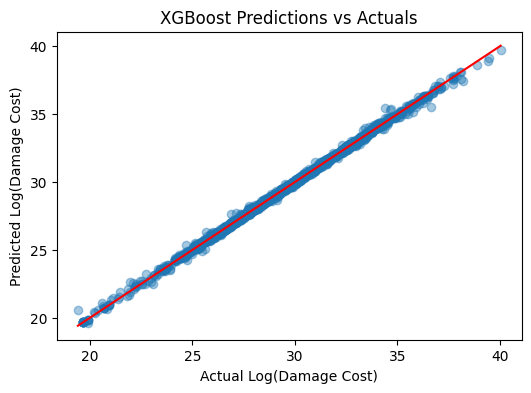

In [33]:
# STEP 7: Residual Plot (optional)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, xgb_preds, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel("Actual Log(Damage Cost)")
plt.ylabel("Predicted Log(Damage Cost)")
plt.title("XGBoost Predictions vs Actuals")
plt.show()

In [34]:
import numpy as np
import pandas as pd

# Extract row 0
sample_row = final_df.iloc[4].copy()

# Feature engineering
sample_row['pop_density'] = sample_row['population'] / sample_row['gis_acres']
sample_row['log_buildvalue'] = np.log1p(sample_row['buildvalue'])
sample_row['log_pop_density'] = np.log1p(sample_row['pop_density'])

# Derive season from alarm_date month
def season_from_month(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

sample_row['season'] = season_from_month(sample_row['alarm_date'].month)

# One-hot encode seasons
for s in ['Winter', 'Spring', 'Summer', 'Fall']:
    sample_row[f'season_{s}'] = 1 if sample_row['season'] == s else 0

# Use the features in EXACT order model expects
features = [
    'precipitation',
    'max_temp',
    'min_temp',
    'avg_wind_speed',
    'lagged_precipitation',
    'lagged_avg_wind_speed',
    'population',
    'season_Winter',
    'season_Spring',
    'season_Summer',
    'season_Fall',
    'log_buildvalue',
    'log_pop_density'
]

X_sample = pd.DataFrame([sample_row[features]])

# Predict and invert log transform
log_pred = xgb.predict(X_sample)[0]
predicted_damage_cost = np.expm1(log_pred)

print(f"Predicted damage cost for the fifth row: ${predicted_damage_cost:,.2f}")


Predicted damage cost for the fifth row: $129,800,127,643,648.00


#### Summary (Predicting Damage Cost):

To estimate wildfire damage costs, we used both linear regression and XGBoost, incorporating fire characteristics, built environment data, and population vulnerability. The linear regression model performed well (R² = 0.993), suggesting a strong linear relationship between the predictors and damage cost. However, XGBoost significantly outperformed it, achieving an even higher R² of 0.999 with lower RMSE and MAE, indicating excellent predictive accuracy, especially for complex and nonlinear patterns in the data. These results highlight the effectiveness of combining structured data (e.g., housing density, fire size, vulnerability indices) with a powerful model like XGBoost to predict fire-related financial impacts. 

### Step 4: Statistical Tests

Determining if patterns observed in the data are likely to be real or just due to random chance.

### a. Two-Sample T-Test: Fire causes resulting in higher estimated annual losses

#### Introduction: 

To investigate whether the type of fire ignition has a measurable impact on economic outcomes, we conducted a statistical test comparing estimated annual losses (EAL scores) for fires caused by humans versus those caused by lightning. We focused specifically on these causes since they represent two of the most common and distinct ignition categories. By using a two-sample t-test, we tested whether the average EAL score differs significantly between these two groups. This test helps us assess whether the observed differences in economic impact are likely due to the ignition type or simply random variation.

cause_group
Human        12180
Lightning    11745
Name: count, dtype: int64


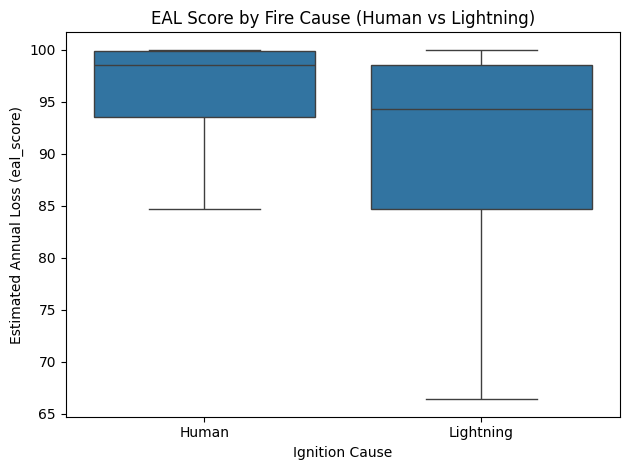

T-statistic: 36.803, p-value: 0.0000


In [35]:
def map_cause_code(code):
    try:
        code = int(code)
    except:
        return 'Unknown'
    
    if 1 <= code <= 9:
        return 'Lightning'
    elif 10 <= code <= 19:
        return 'Human'
    elif 20 <= code <= 29:
        return 'Utility'
    else:
        return 'Other'
    
final_df['cause_group'] = final_df['cause'].apply(map_cause_code)

print(final_df['cause_group'].value_counts())


df_loss = final_df[final_df['cause_group'].isin(['Human', 'Lightning', 'Utility']) & final_df['eal_score'].notna()]
df_loss['eal_score'] = pd.to_numeric(df_loss['eal_score'], errors='coerce')

# Keep only Human and Lightning
df_loss = final_df[final_df['cause_group'].isin(['Human', 'Lightning']) & final_df['eal_score'].notna()]
df_loss['eal_score'] = pd.to_numeric(df_loss['eal_score'], errors='coerce')

# Extract groups
human = df_loss[df_loss['cause_group'] == 'Human']['eal_score']
lightning = df_loss[df_loss['cause_group'] == 'Lightning']['eal_score']

# Plot
sns.boxplot(data=df_loss, x='cause_group', y='eal_score', showfliers=False)
plt.title('EAL Score by Fire Cause (Human vs Lightning)')
plt.ylabel('Estimated Annual Loss (eal_score)')
plt.xlabel('Ignition Cause')
plt.tight_layout()
plt.show()

# Run t-test
t_stat, p_val = ttest_ind(human, lightning, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")


#### Summary (Two-Sample T-Test):

The two-sample t-test comparing estimated annual losses (EAL) between human- and lightning-caused fires revealed a statistically significant difference in means (T = 36.803, p < 0.0001). This result provides strong evidence that fires caused by humans lead to significantly higher financial losses than those caused by lightning. The extremely low p-value indicates that this difference is highly unlikely to be due to random chance.

### a. Chi-Squared Test: Fire Season Affecting Fire Behavior

#### Introduction: 

To examine whether wildfire size is associated with the season in which a fire occurs, we used a Chi-squared test of independence. Fire incidents were categorized into three size groups—small, medium, and large—based on their reported acreage. We then created a contingency table showing the frequency of each fire size category across different seasons. The Chi-squared test was applied to this table to determine whether the distribution of fire sizes varies significantly by season, or if these two variables appear to be statistically independent. This analysis helps assess whether seasonal patterns play a meaningful role in shaping wildfire behavior.

In [36]:
# Bin gis_acres into size categories
bins = [0, 100, 1000, final_df['gis_acres'].max()]
labels = ['Small', 'Medium', 'Large']
final_df['size_cat'] = pd.cut(final_df['gis_acres'], bins=bins, labels=labels, include_lowest=True)

# Filter to rows with valid season and size category
df_chi = final_df.dropna(subset=['season', 'size_cat'])

# Contingency table: fire size category by season
contingency = pd.crosstab(df_chi['size_cat'], df_chi['season'])

print(contingency)

# Run Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi2 Statistic: {chi2:.3f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p:.4f}")


season    Winter  Spring  Summer  Fall
size_cat                              
Small        278     875    3834  1448
Medium        71     351    2066   710
Large         43     137    1404   489
Chi2 Statistic: 129.073
Degrees of Freedom: 6
P-value: 0.0000


#### Summary (Chi-Squared Test):

The Chi-squared test showed a significant association between fire season and fire size category (χ² = 129.073, df = 6, p < 0.0001), indicating that wildfire size distributions differ across seasons. The contingency table reveals that larger fires are more common in the summer, while smaller fires dominate in spring and winter. This supports the conclusion that seasonal conditions—such as temperature, dryness, and fuel availability—likely influence how large fires grow, with summer presenting the most favorable conditions for large fire spread.